In [ ]:
!pip install statsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 13.7 MB/s eta 0:00:00
  Created wheel for fugue-sql-antlr: filename=fugue_sql_antlr-0.2.0-py3-none-any.whl size=158196 sha256=70e1724c85c8132c92b9ae18bed06003ef1ce56225f7f299d0068279639b95de
  Stored in directory: /root/.cache/pip/wheels/5a/b5/4e/216953a1c711da55de29ed7ecf158b4a5bf32ef93d69ad66dd
Successfully built fugue-sql-antlr


In [ ]:
# importanto as bibliotecas
import numpy as np
from numpy import mean
from scipy import stats
import math
import pandas as pd
#import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from scipy import stats
from datetime import date, time, datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA, AutoETS, HoltWinters
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation # validação de métricas
from prophet.diagnostics import performance_metrics # validação de métricas

sns.set_theme(style="whitegrid", palette="pastel")

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
ipeadata = pd.read_html(r"http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view", encoding='utf-8', header=0)[2]

In [ ]:
ipeadata.head(20)

,Data,Preço - petróleo bruto - Brent (FOB)
0,16/01/2024,8015
1,15/01/2024,7976
2,12/01/2024,7989
3,11/01/2024,8021
4,10/01/2024,7846
5,09/01/2024,7797
6,08/01/2024,7547
7,05/01/2024,7831
8,04/01/2024,7579
9,03/01/2024,7718


In [ ]:
ipeadata.shape

(11088, 2)

In [ ]:
ipeadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11088 entries, 0 to 11087
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Data                                  11088 non-null  object
 1   Preço - petróleo bruto - Brent (FOB)  11088 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 173.4+ KB


In [ ]:
cols = ['data', 'preco']

In [ ]:
ipeadata.columns = cols

In [ ]:
ipeadata.preco = ipeadata.preco/100

In [ ]:
ipeadata['data'] = pd.to_datetime(ipeadata['data'], format="%d/%m/%Y")

In [ ]:
ipeadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11088 entries, 0 to 11087
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    11088 non-null  datetime64[ns]
 1   preco   11088 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 173.4 KB


In [ ]:
ipeadata = ipeadata.set_index('data')

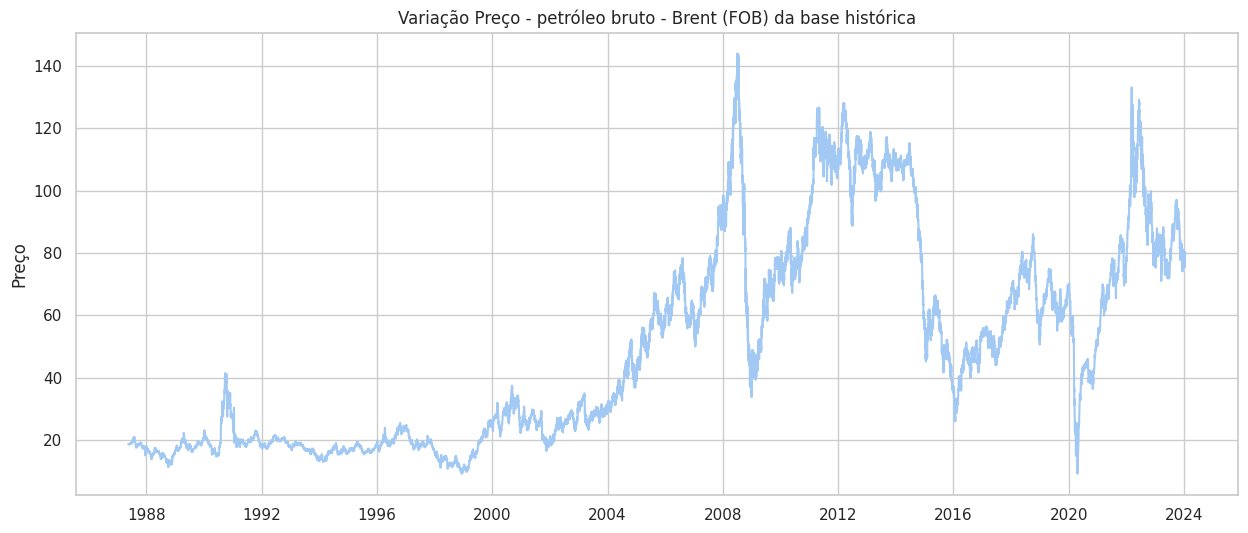

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(data=ipeadata, x='data', y='preco')
plt.xlabel("")
plt.ylabel("Preço")
plt.title("Variação Preço - petróleo bruto - Brent (FOB) da base histórica")
plt.show()

In [ ]:
ipeadata_copia = ipeadata.copy()
ipeadata_copia.head()


,preco
data,
2024-01-16,80.15
2024-01-15,79.76
2024-01-12,79.89
2024-01-11,80.21
2024-01-10,78.46


In [ ]:
resultado_seasonal_decompose = seasonal_decompose(ipeadata_copia, period=5, model='multiplicative')

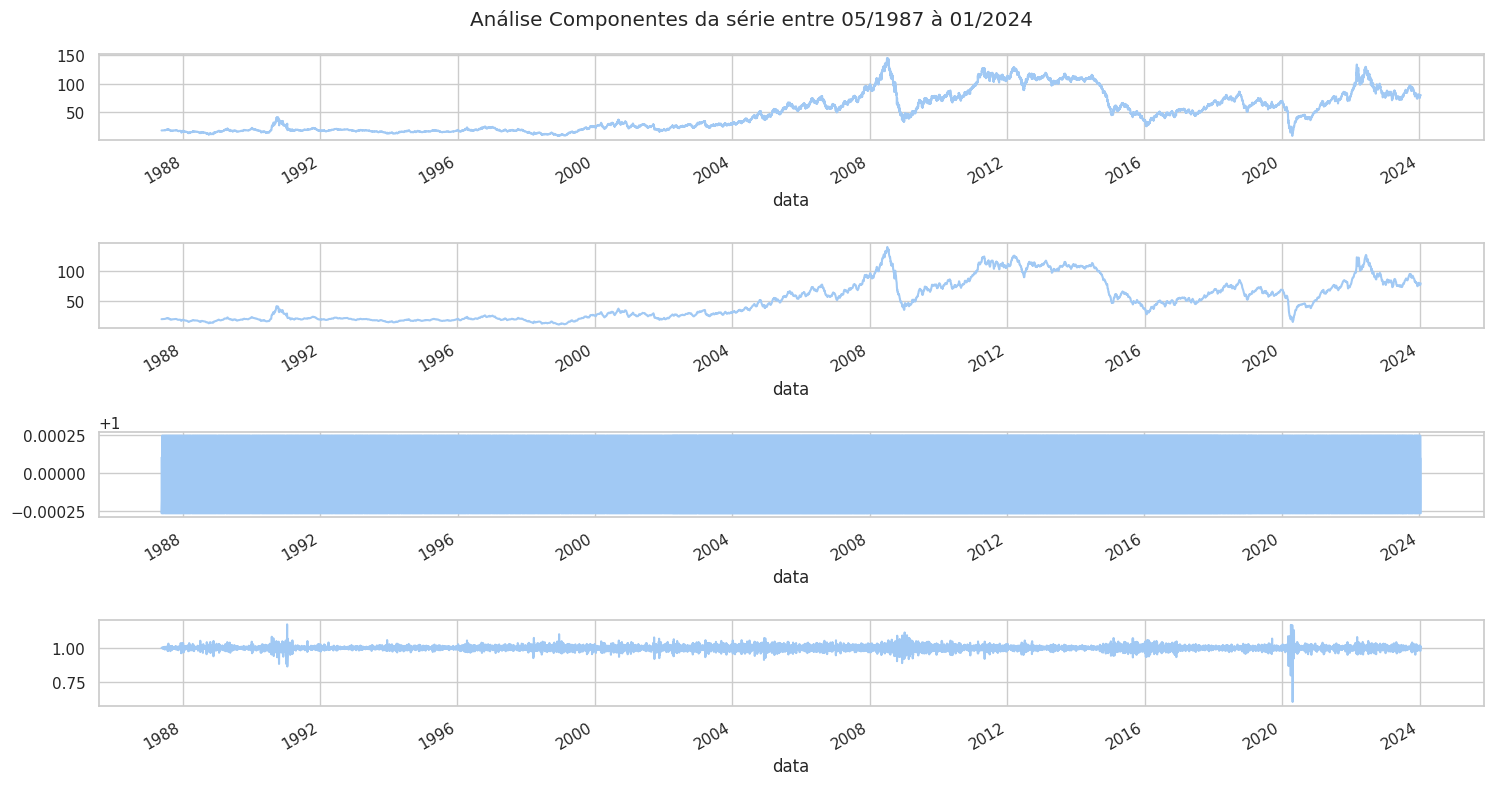

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,8))
plt.suptitle("Análise Componentes da série entre 05/1987 à 01/2024")
resultado_seasonal_decompose.observed.plot(ax=ax1) # observação dos gráficos ao longo do tempo
resultado_seasonal_decompose.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultado_seasonal_decompose.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultado_seasonal_decompose.resid.plot(ax=ax4) # residuos que não necessariamente fazem sentido - IMPORTANTE AVALIAR

plt.tight_layout()
plt.show()

In [ ]:
ipeadata_copia

,preco
data,
2024-01-16,80.15
2024-01-15,79.76
2024-01-12,79.89
2024-01-11,80.21
2024-01-10,78.46
...,...
1987-05-26,18.63
1987-05-25,18.60
1987-05-22,18.55


<ipython-input-18-74cfcdd87392>:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_2023 = ipeadata_copia.loc['2023-01-01':]


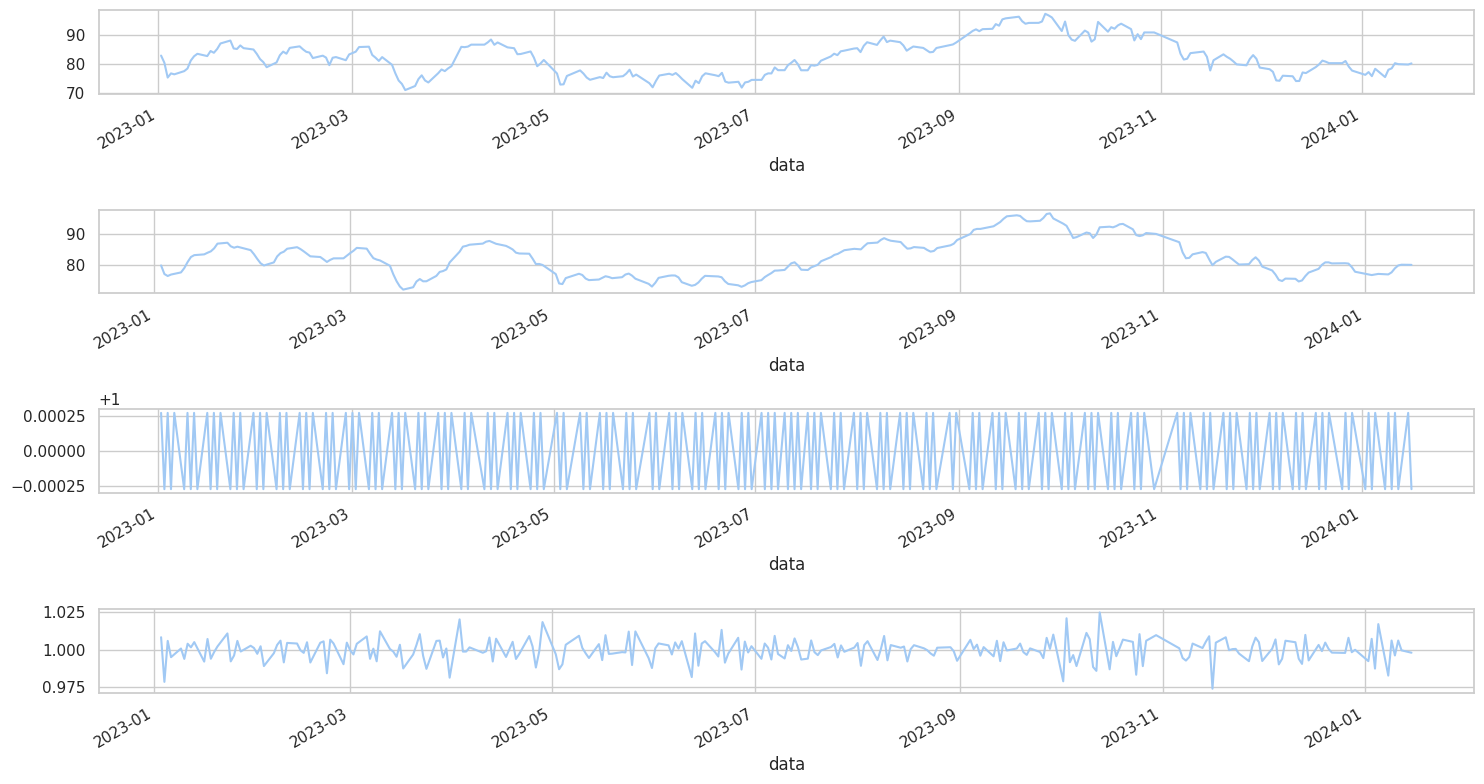

In [ ]:
df_2023 = ipeadata_copia.loc['2023-01-01':]
seasonplot = seasonal_decompose(df_2023, model='multiplicative', period=2) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

In [ ]:
df = ipeadata_copia

In [ ]:
ipeadata_copia

,preco
data,
2024-01-16,80.15
2024-01-15,79.76
2024-01-12,79.89
2024-01-11,80.21
2024-01-10,78.46
...,...
1987-05-26,18.63
1987-05-25,18.60
1987-05-22,18.55


In [ ]:
df = df[::-1]

In [ ]:
df.reset_index(inplace=True)
df

,data,preco
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
11083,2024-01-10,78.46
11084,2024-01-11,80.21
11085,2024-01-12,79.89
11086,2024-01-15,79.76


In [ ]:
df['MA_window_10'] = df['preco'].rolling(10).mean().shift() #média móvel em 10 dias
df['MA_window_30'] = df['preco'].rolling(30).mean().shift() #média móvel em 30 dias

<ipython-input-23-974ecf74fd62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA_window_10'] = df['preco'].rolling(10).mean().shift() #média móvel em 10 dias
<ipython-input-23-974ecf74fd62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA_window_30'] = df['preco'].rolling(30).mean().shift() #média móvel em 30 dias


In [ ]:
df

,data,preco,MA_window_10,MA_window_30
0,1987-05-20,18.63,NaN,NaN
1,1987-05-21,18.45,NaN,NaN
2,1987-05-22,18.55,NaN,NaN
3,1987-05-25,18.60,NaN,NaN
4,1987-05-26,18.63,NaN,NaN
...,...,...,...,...
11083,2024-01-10,78.46,77.889,78.067667
11084,2024-01-11,80.21,77.712,78.033333
11085,2024-01-12,79.89,77.636,77.985000
11086,2024-01-15,79.76,77.721,77.882000


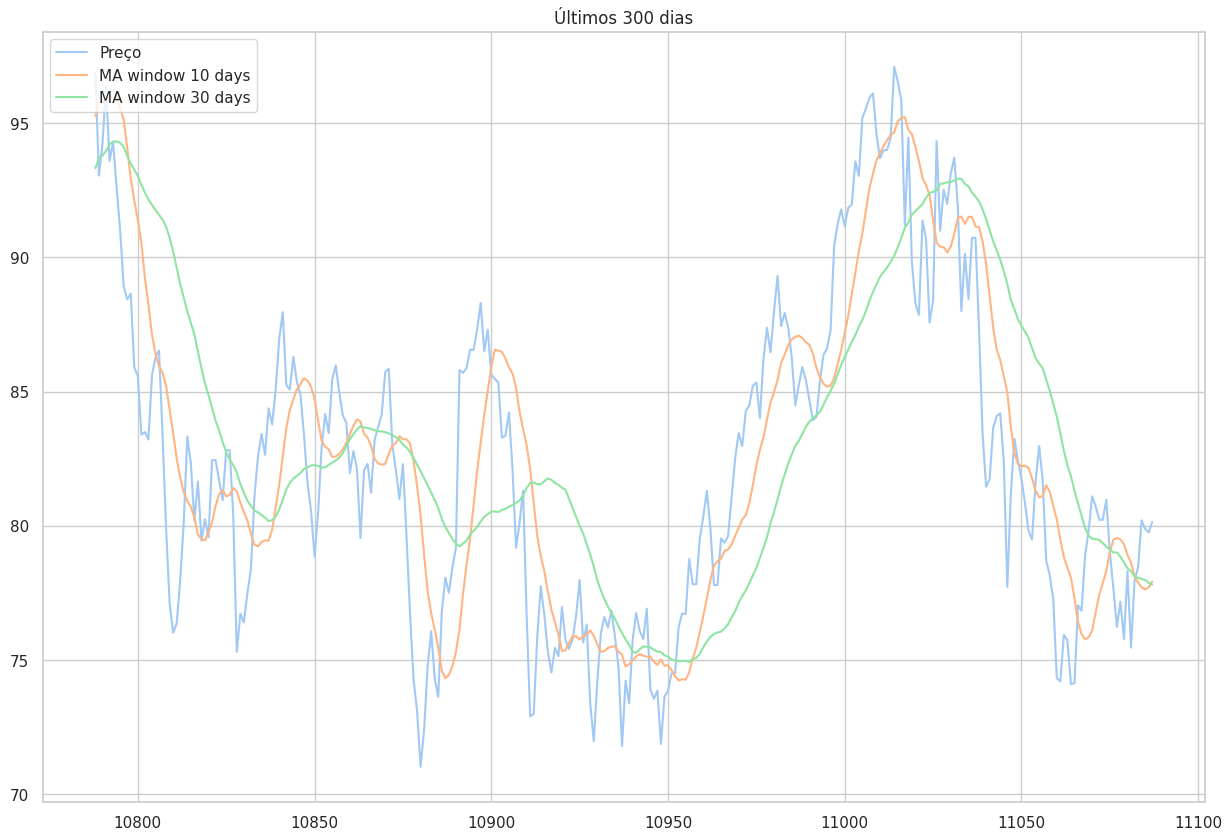

In [ ]:
limit = 300

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['preco'][-limit:], label='Preço')
plt.plot(df['MA_window_10'][-limit:], label='MA window 10 days')
plt.plot(df['MA_window_30'][-limit:], label='MA window 30 days')
plt.legend(loc=2)
plt.title('Últimos 300 dias')
plt.show()

In [ ]:
df['MA_window_10_forward_10'] = np.NaN #preechendo com NaN os valores da coluna de MA_window_10_forward_10

<ipython-input-26-ef1e1440a16e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA_window_10_forward_10'] = np.NaN #preechendo com NaN os valores da coluna de MA_window_10_forward_10


In [ ]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]  #realizando a janela de tempo

In [ ]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['preco'].iloc[window_close], df['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_10_forward_10')] = mean

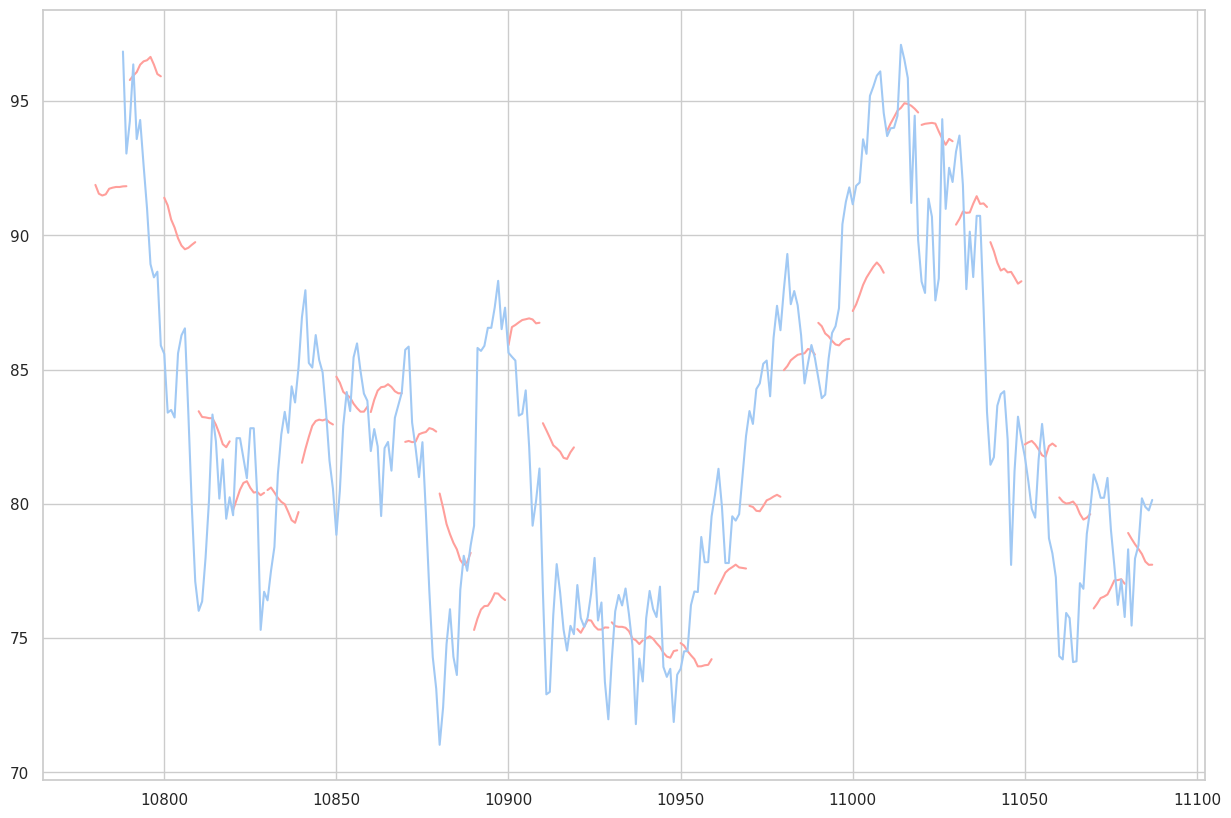

In [ ]:
plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df['preco'][-limit:], color='b', label='Preço')
#plt.legend(loc='best')
plt.show()

## Prophet

In [ ]:
df = df[['data','preco']]

In [ ]:
df[['ds','y']] = df[['data','preco']]
df.head()

<ipython-input-31-20ffce61dfa8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['ds','y']] = df[['data','preco']]
<ipython-input-31-20ffce61dfa8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['ds','y']] = df[['data','preco']]


,data,preco,ds,y
0,1987-05-20,18.63,1987-05-20,18.63
1,1987-05-21,18.45,1987-05-21,18.45
2,1987-05-22,18.55,1987-05-22,18.55
3,1987-05-25,18.60,1987-05-25,18.60
4,1987-05-26,18.63,1987-05-26,18.63


## Separando entre treino e teste

In [ ]:
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (8870, 4)
testing data size : (2218, 4)


In [ ]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpysrcfqsh/_yph6jel.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpysrcfqsh/3m9_n94o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70720', 'data', 'file=/tmp/tmpysrcfqsh/_yph6jel.json', 'init=/tmp/tmpysrcfqsh/3m9_n94o.json', 'output', 'file=/tmp/tmpysrcfqsh/prophet_modelfm2jjkwm/prophet_model-20240123195318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1987-05-21,17.681666,4.964431,30.375063,17.681666,17.681666,-0.181747,-0.181747,-0.181747,-1.694614,...,-0.002218,-0.002218,-0.002218,1.515086,1.515086,1.515086,0.0,0.0,0.0,17.499920
1,1987-05-22,17.684982,4.179675,30.948518,17.684982,17.684982,-0.204015,-0.204015,-0.204015,-1.694614,...,-0.015701,-0.015701,-0.015701,1.506301,1.506301,1.506301,0.0,0.0,0.0,17.480967
2,1987-05-25,17.694929,2.771699,31.331094,17.694929,17.694929,-0.168246,-0.168246,-0.168246,-1.694614,...,0.076845,0.076845,0.076845,1.449523,1.449523,1.449523,0.0,0.0,0.0,17.526683
3,1987-05-26,17.698245,4.874537,31.225632,17.698245,17.698245,-0.353876,-0.353876,-0.353876,-1.694614,...,-0.081341,-0.081341,-0.081341,1.422078,1.422078,1.422078,0.0,0.0,0.0,17.344368
4,1987-05-27,17.701560,5.310171,31.189672,17.701560,17.701560,-0.457106,-0.457106,-0.457106,-1.694614,...,-0.153926,-0.153926,-0.153926,1.391434,1.391434,1.391434,0.0,0.0,0.0,17.244454


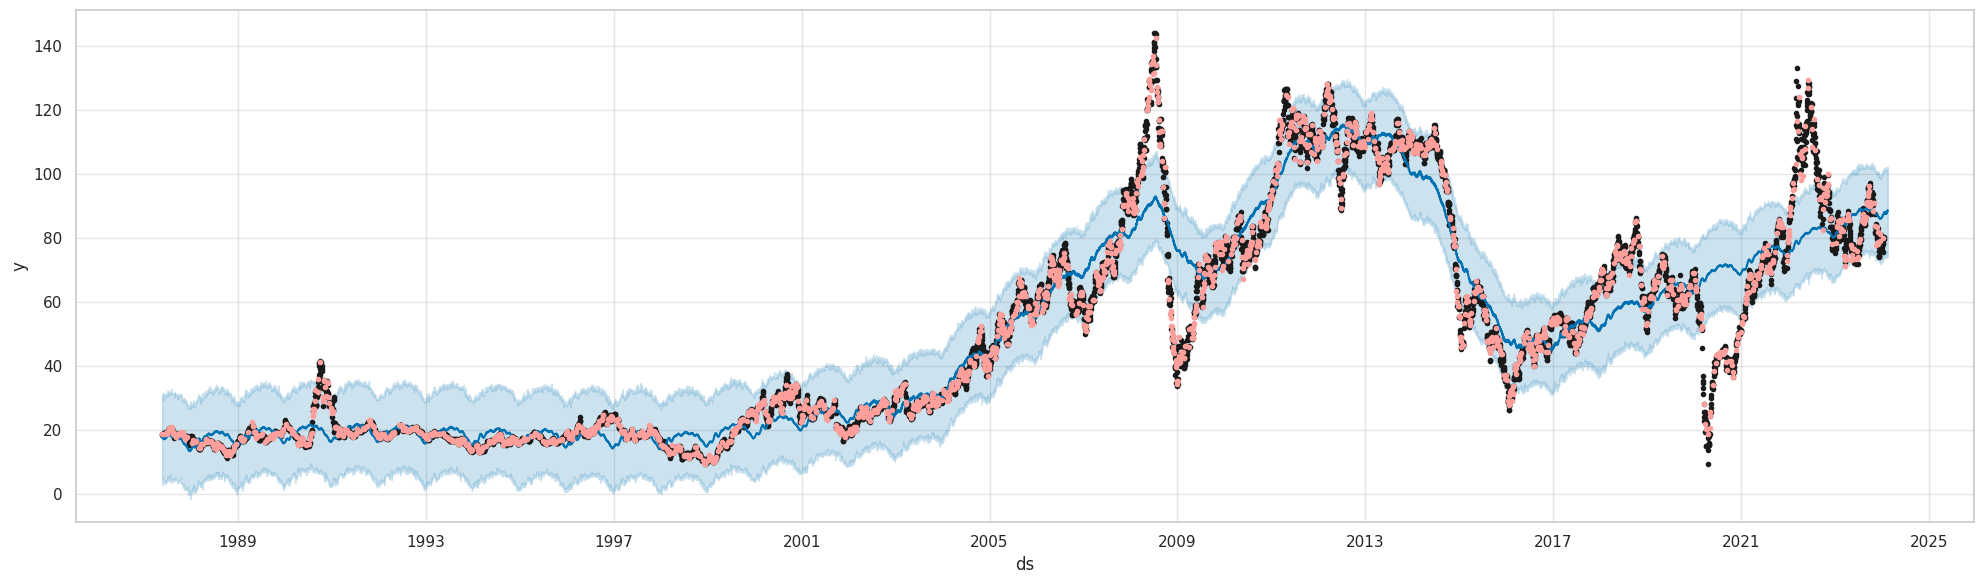

In [ ]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

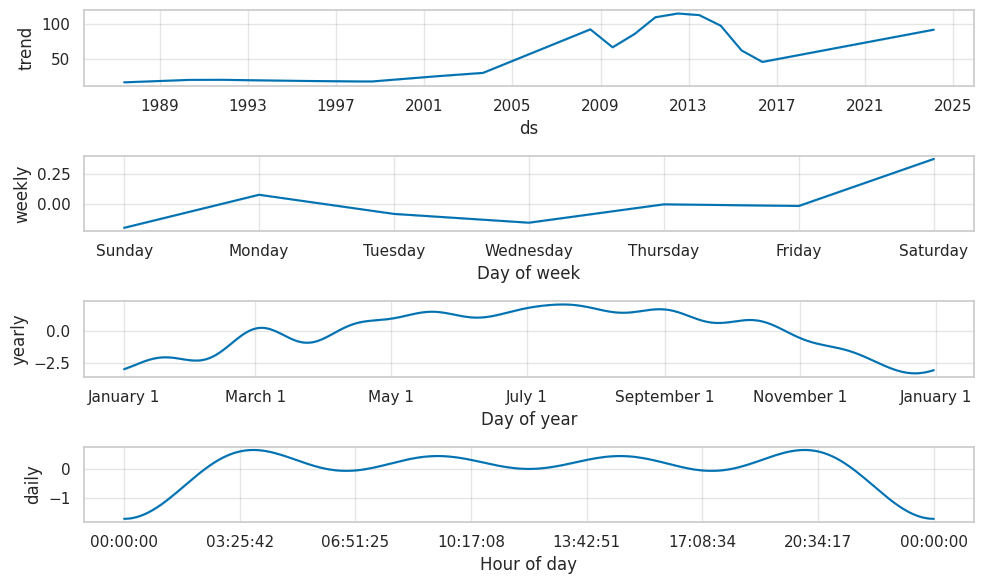

In [ ]:
modelo.plot_components(previsao, figsize=(10,6));

In [ ]:
from prophet.plot import add_changepoints_to_plot

modelo_changepoints = Prophet(n_changepoints=5)
modelo_changepoints.fit(train_data)
dataFramefuture = modelo_changepoints.make_future_dataframe(periods=30, freq='D')
previsao_changepoints = modelo_changepoints.predict(dataFramefuture)
previsao_changepoints.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpysrcfqsh/jkf5d7w0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpysrcfqsh/t6ewrdcq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=394', 'data', 'file=/tmp/tmpysrcfqsh/jkf5d7w0.json', 'init=/tmp/tmpysrcfqsh/t6ewrdcq.json', 'output', 'file=/tmp/tmpysrcfqsh/prophet_modelvshwirwh/prophet_model-20240123195330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1987-05-21,18.195856,1.807302,37.723937,18.195856,18.195856,1.656930,1.656930,1.656930,0.183225,0.183225,0.183225,1.473705,1.473705,1.473705,0.0,0.0,0.0,19.852786
1,1987-05-22,18.195883,0.262018,37.288524,18.195883,18.195883,1.633542,1.633542,1.633542,0.194401,0.194401,0.194401,1.439141,1.439141,1.439141,0.0,0.0,0.0,19.829425
2,1987-05-25,18.195964,0.851508,36.963797,18.195964,18.195964,1.602843,1.602843,1.602843,0.295041,0.295041,0.295041,1.307802,1.307802,1.307802,0.0,0.0,0.0,19.798807
3,1987-05-26,18.195992,1.275779,37.739907,18.195992,18.195992,1.246228,1.246228,1.246228,-0.012080,-0.012080,-0.012080,1.258309,1.258309,1.258309,0.0,0.0,0.0,19.442220
4,1987-05-27,18.196019,0.459521,37.899812,18.196019,18.196019,1.265098,1.265098,1.265098,0.057251,0.057251,0.057251,1.207847,1.207847,1.207847,0.0,0.0,0.0,19.461117


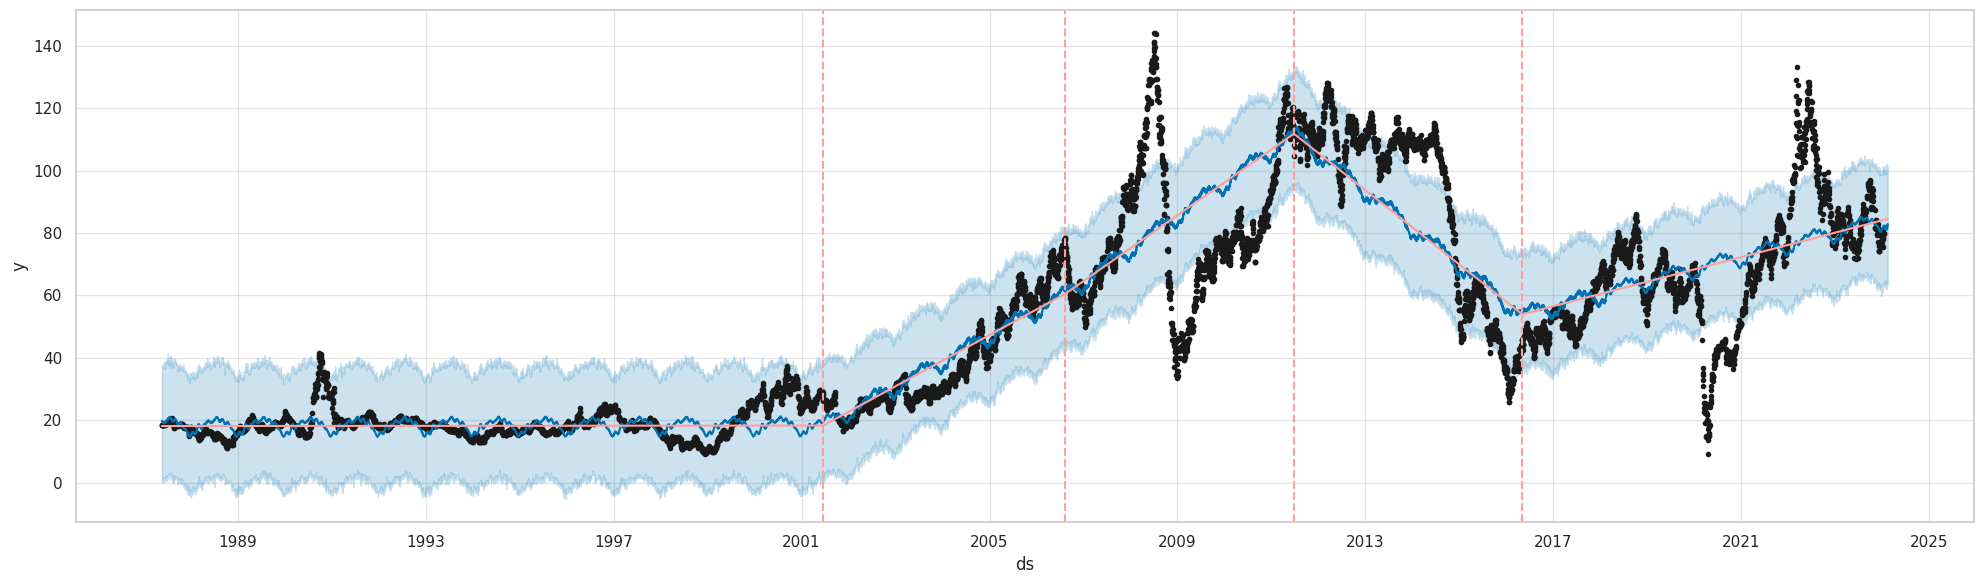

In [ ]:
fig = modelo_changepoints.plot(previsao_changepoints, figsize=(20,6));
a = add_changepoints_to_plot(fig.gca(), modelo_changepoints, previsao_changepoints)

Invasão do Kuwait pela Iraque (1990):
A invasão do Kuwait pelo Iraque em 1990 desencadeou a Guerra do Golfo, levando a preocupações sobre a oferta de petróleo na região do Golfo Pérsico e resultando em um aumento significativo nos preços do petróleo.

Crise Financeira Asiática (1997-1998):
A crise financeira asiática afetou a demanda global por petróleo devido à contração econômica em vários países asiáticos, resultando em uma queda nos preços do petróleo.

Ataques de 11 de setembro (2001):
Os ataques terroristas de 11 de setembro de 2001 nos Estados Unidos geraram incertezas globais e levaram a preocupações com a segurança energética, contribuindo para a volatilidade nos preços do petróleo.

Guerra no Iraque (2003):
A invasão do Iraque liderada pelos EUA em 2003 levantou preocupações sobre a estabilidade da produção de petróleo na região e resultou em aumentos nos preços do petróleo.

Crise Financeira Global (2008):
A crise financeira global de 2008 resultou em uma recessão econômica global, reduzindo a demanda por petróleo e causando uma queda acentuada nos preços do petróleo.

Primavera Árabe (2010-2011):
Os levantes durante a Primavera Árabe afetaram a produção de petróleo em alguns países do Oriente Médio, contribuindo para a volatilidade nos preços.

Sanções à Rússia (2014):
As sanções econômicas impostas à Rússia devido à anexação da Crimeia contribuíram para a volatilidade nos preços do petróleo.

Acordo Nuclear Iraniano (2015):
O acordo nuclear com o Irã em 2015 levou à suspensão de algumas sanções, resultando em um aumento potencial na oferta de petróleo e impactando os preços.

Pandemia de COVID-19 (2020):
A pandemia global de COVID-19 em 2020 causou uma redução abrupta na demanda por petróleo devido a bloqueios e desaceleração econômica, resultando em uma queda histórica nos preços do petróleo.

In [76]:

# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 15.41%


## Cross validation

Para concluir o modelo do Prophet, tentei fazer a validação cruzada para testar dados que nunca foram vistos pelo modelo antes.

Observe que no resultado da validação cruzada temos os valores de yhat, yhat_lower, yhat_upper e o ponto de corte. O objetivo da validação cruzada é medir o erro de predição, selecionando assim pontos de corte e para cada um desses pontos o modelo é ajustado utilizando dados apenas até aquele ponto de corte.


In [ ]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')


INFO:prophet:Making 69 forecasts with cutoffs between 1989-07-13 00:00:00 and 2023-01-16 00:00:00


  0%|          | 0/69 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpysrcfqsh/u7y_jrv5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpysrcfqsh/jges7w9e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99181', 'data', 'file=/tmp/tmpysrcfqsh/u7y_jrv5.json', 'init=/tmp/tmpysrcfqsh/jges7w9e.json', 'output', 'file=/tmp/tmpysrcfqsh/prophet_model4avhfaoj/prophet_model-20240123195714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpysrcfqsh/jqnj5j1f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpysrcfqsh/x1dhwwhb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_cv['cutoff'].unique()

array(['1989-07-13T00:00:00.000000000', '1990-01-09T00:00:00.000000000',
       '1990-07-08T00:00:00.000000000', '1991-01-04T00:00:00.000000000',
       '1991-07-03T00:00:00.000000000', '1991-12-30T00:00:00.000000000',
       '1992-06-27T00:00:00.000000000', '1992-12-24T00:00:00.000000000',
       '1993-06-22T00:00:00.000000000', '1993-12-19T00:00:00.000000000',
       '1994-06-17T00:00:00.000000000', '1994-12-14T00:00:00.000000000',
       '1995-06-12T00:00:00.000000000', '1995-12-09T00:00:00.000000000',
       '1996-06-06T00:00:00.000000000', '1996-12-03T00:00:00.000000000',
       '1997-06-01T00:00:00.000000000', '1997-11-28T00:00:00.000000000',
       '1998-05-27T00:00:00.000000000', '1998-11-23T00:00:00.000000000',
       '1999-05-22T00:00:00.000000000', '1999-11-18T00:00:00.000000000',
       '2000-05-16T00:00:00.000000000', '2000-11-12T00:00:00.000000000',
       '2001-05-11T00:00:00.000000000', '2001-11-07T00:00:00.000000000',
       '2002-05-06T00:00:00.000000000', '2002-11-02

In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,309.663349,17.597254,12.413303,0.231008,0.164831,0.225763,0.390417
1,38 days,313.839038,17.715503,12.523078,0.232958,0.167159,0.227646,0.385842
2,39 days,317.862491,17.828699,12.609763,0.234614,0.168502,0.229332,0.384985
3,40 days,321.937176,17.942608,12.690463,0.237216,0.170432,0.231731,0.382222
4,41 days,324.980550,18.027217,12.756349,0.238700,0.171214,0.233219,0.379680
...,...,...,...,...,...,...,...,...
324,361 days,830.935731,28.825956,21.063137,0.436912,0.269674,0.423089,0.333728
325,362 days,827.778527,28.771141,21.025064,0.435557,0.270448,0.422646,0.331918
326,363 days,828.580773,28.785079,21.066592,0.435238,0.269992,0.423869,0.329371
327,364 days,830.455764,28.817629,21.099719,0.436538,0.270785,0.424735,0.327834


In [ ]:
df.head()

,data,preco,ds,y
0,1987-05-20,18.63,1987-05-20,18.63
1,1987-05-21,18.45,1987-05-21,18.45
2,1987-05-22,18.55,1987-05-22,18.55
3,1987-05-25,18.60,1987-05-25,18.60
4,1987-05-26,18.63,1987-05-26,18.63


### Aplicando o algoritmo LSTM para prever 🤖

Vamos agora utilizar uma Rede LSTM (Long Short-Term Memory) para prever o comportamento dos preços.

LSTM é um tipo especial de **rede neural recorrente**, pois são capazes de aprender conexões de longo prazo. Dessa maneira, elas têm um incrível poder de predição e funcionam muito bem em uma variada gama de problemas que envolvem capturas de padrões de longo prazo em séries temporais, textos longos, gravações de áudios e muito mais. O principal trabalho dessa rede neural se torna entender como uma memória deve influenciar a outra, ou seja, como a rede decide quais partes da memória de curto prazo devem ser lembradas e como a memória de longo prazo deve afetar o entendimento atual do texto.


In [ ]:
df = df[['data','preco']]

In [ ]:
close_data = df['preco'].values
close_data = close_data.reshape(-1,1) #transformar em array

In [ ]:
# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [ ]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['data'][:split]
date_test = df['data'][split:]

print(len(close_train))
print(len(close_test))

8870
2218


In [ ]:
# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [ ]:
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
443/443 [==============================] - 9s 11ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 2/20
443/443 [==============================] - 4s 9ms/step - loss: 3.6272e-04 - mean_squared_error: 3.6272e-04
Epoch 3/20
443/443 [==============================] - 8s 19ms/step - loss: 3.8099e-04 - mean_squared_error: 3.8099e-04
Epoch 4/20
443/443 [==============================] - 4s 8ms/step - loss: 2.8919e-04 - mean_squared_error: 2.8919e-04
Epoch 5/20
443/443 [==============================] - 5s 11ms/step - loss: 3.4163e-04 - mean_squared_error: 3.4163e-04
Epoch 6/20
443/443 [==============================] - 4s 9ms/step - loss: 3.3550e-04 - mean_squared_error: 3.3550e-04
Epoch 7/20
443/443 [==============================] - 4s 9ms/step - loss: 2.9360e-04 - mean_squared_error: 2.9360e-04
Epoch 8/20
443/443 [==============================] - 4s 9ms/step - loss: 3.5092e-04 - mean_squared_error: 3.5092e-04
Epoch 9/20
443/443 [==============================] - 4s 8ms/

In [ ]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

2208/2208 [==============================] - 12s 5ms/step - loss: 2.2838e-04 - mean_squared_error: 2.2838e-04
Erro Quadrático Médio 0.00022837522556073964


In [ ]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')


2208/2208 [==============================] - 13s 6ms/step
MAPE: 4.9249


In [ ]:
#O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.01511208872263327


O RMSE fornece uma métrica de erro na mesma unidade que a variável alvo (nesse caso, o preço de fechamento). Portanto significa que, em média, as previsões do modelo estão desviando em torno de 0.15 unidades da variável de destino. Quanto menor o RMSE, melhor é o desempenho do modelo em termos de previsões de regressão.

In [ ]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições do Brent",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

2208/2208 [==============================] - 16s 7ms/step


# Realizando o Forecasting  🔮

Agora chegou o momento de prever o futuro!

Vamos criar uma função para prever o futuro, vamos passar como parametro um  número X de dias e a ideia dessa função é excutar o predict do modelo para nos retornar os dias futuros.

In [ ]:
close_data = close_data.reshape((-1))


# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'data' contendo as datas

def predict_dates(num_prediction):
    last_date = df['data'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 15 #definição dos próximos dias
forecast = predict(num_prediction, model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 28ms/step


In [ ]:
trace1 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast Brent",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

# Organizando os dados em um dataframe

In [ ]:
df = pd.DataFrame(df)
df_past = df[['data','preco']]
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['preco'].iloc[-1]
df_past.head(3)

<ipython-input-67-073aa279dfbd>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,data,preco,Forecast
0,1987-05-20,18.63,NaN
1,1987-05-21,18.45,NaN
2,1987-05-22,18.55,NaN


In [ ]:
# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast)

In [ ]:
df_future = pd.DataFrame(columns=['data', 'preco', 'Forecast'])
df_future['data'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['preco'] = np.nan
df_future.head(10)

,data,preco,Forecast
0,2024-01-16,NaN,80.150000
1,2024-01-17,NaN,80.202041
2,2024-01-18,NaN,80.337540
3,2024-01-19,NaN,80.419339
4,2024-01-20,NaN,80.513638


In [ ]:
df_future.head(10)

,data,preco,Forecast
0,2024-01-16,NaN,80.150000
1,2024-01-17,NaN,80.202041
2,2024-01-18,NaN,80.337540
3,2024-01-19,NaN,80.419339
4,2024-01-20,NaN,80.513638
5,2024-01-21,NaN,80.589497
6,2024-01-22,NaN,80.657970
7,2024-01-23,NaN,80.726741
8,2024-01-24,NaN,80.801194
9,2024-01-25,NaN,80.871507


In [ ]:
# Concatenando os DataFrames usando concat
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('data')
results.head()

,preco,Forecast
data,,
1987-05-20,18.63,NaN
1987-05-21,18.45,NaN
1987-05-22,18.55,NaN
1987-05-25,18.60,NaN
1987-05-26,18.63,NaN


In [ ]:
results2023 =  results.loc['2023-01-01':]

In [ ]:
plot_data = [
    go.Scatter(
        x=results2023.index,
        y=results2023['preco'],
        name='actual'
    ),
    go.Scatter(
        x=results2023.index,
        y=results2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast Brent'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

import plotly as ply
ply.offline.plot(fig)

'temp-plot.html'

In [ ]:
results.tail()

,preco,Forecast
data,,
2024-01-27,NaN,81.006573
2024-01-28,NaN,81.074202
2024-01-29,NaN,81.141823
2024-01-30,NaN,81.208954
2024-01-31,NaN,81.275956
